In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("project_134.ipynb")

# Final Project 
    
## PSTAT 134(Winter 2024) 


In [3]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user, $i = 1,2,\ldots, I$, $m = 1,\ldots,M$. (We won't discuss the role of $\alpha$ in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha D_{m1}\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha D_{m2}\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha D_{mI}\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D_{m-}\circ\Gamma_{m-})^T v_m,
\end{aligned}
$$
where $I_{m-}$ and $\Gamma_{m-}$ are the $m$-th row of $\Gamma$ and $D$ (use the notation $\Gamma_{-i}$ for the $i$-th column). Hadamard product (elementwise matrix product) is denoted with $\circ$. When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

**SOLUTION**

$$ 
\begin{aligned}
U^{\text{new}} &= U + 2\alpha*\Gamma^T V\\
V^{\text{new}} &= V + 2\alpha*\Gamma U\\
\end{aligned} 
$$

<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [4]:
import numpy as np
import pandas as pd

def update_G(R_, U_, V_):
    
    return R_ - np.dot(V_, U_.T)

def update_U(G_, U_, V_, alpha=0.01):
    
    return np.nan_to_num(U_ + 2 * alpha * np.dot(np.nan_to_num(G_.T), V_))

def update_V(G_, U_, V_, alpha=0.01):
    
    return np.nan_to_num(V_ + 2 * alpha * np.dot(np.nan_to_num(G_), U_))

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [6]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [6]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [7]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [9]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [10]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [11]:
## TEST ##
output2['U'].shape

(5, 8)

In [12]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [13]:
## TEST ##
output2['V'].shape

(7, 8)

In [14]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [15]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [16]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [17]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [10]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

alt.VConcatChart(...)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

***RMSE vs. Iteration:*** \
**Description:** The root mean squared error measures the difference between the algorithm's predictions and the actual data. This graph shows how the RMSE decreases exponentially as the number of iterations increases, which is plotted on a logarithmic scale. \
**Interpretation:** As the RMSE decreases as the number of iterations increases, this shows us that the algorithm is improving and refining its predictions as it goes through more and more iterations. 

***Maximum Residual Change vs. Iteration:*** \
**Description:** The maximum residual change measures the largest residual change from each iteration on a logarithmic scale. Based on the plot, we can see that the graph first decreases dramatically, and then slowly and steadily decreases as the number of iterations increase. \
**Interpretation:** As the maximum residual change decreases as the number of iterations increases, this shows us that the model makes the largest improvements in the first few iterations. Over time, as the algorithm goes through more and more iterations, it begins to slowly adjust and improve. This shows that the algorithm is stabilizing as the difference between the predicted and actual values begins to decrease. 

***Maximum Update vs. Iteration:*** \
**Description:** Maximum update measures the largest change in the values of the U and V matrices over every iteration on a logarithmic scale. Based on the plot, we can see that for the first 500 iterations, the maximum update sharply increases and decreases. From there, the maximum updates overall decreases, with a few spikes throughout. \
**Interpretation:** The sharp spikes for the first 500 or so iterations indicate that the algorithm is traversing through different solutions to find the optimal configurations for each matrix. As more iterations occur, the algorithm begins to decrease overall as the matrices converge towards their optimal configurations. However, there are some spikes throughout these iterations, meaning that while overall the algorithm is learning the best maximum values, but there may be some instability throughout. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [12]:
# run on larger dataset
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()[100:]

np.random.seed(134) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

In [13]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

/tmp/ipykernel_72/1847306426.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ], axis=1).stack().dropna().reset_index()[['fit','observed']]


alt.Chart(...)

**Question**: Consider the above plot.
- By reading the code, comment on what the plot is illustrating. 
- What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

The plot is illustrating the density distribution comparing the observed ratings to the predicted ratings. There are 5 plots, eaching representing a rating value from 1 to 5 stars. For each plot, the x-axis represents the predicted rating and the y-axis represents the density of those predicted values. The bars in each plot show the distribution of these predicted ratings for each observed value. 

When you add counts=True to transform_density, the plots will show the number of data points within each bin of each density plot instead of the density. Based on these plots, we can see that the predicted distributions are spread out across a wide range of values. We can see as the observed ratings increase, the distribution curve begins to form a normal distribution curve, while also increasing the median of the curve. This indicates that some models are able to show some correlation between the observed and predicted ratings. However, there are still some limitations to how accurately it can predict some ratings, especially the lower ratings. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

In [125]:
Rhatbig.iloc[:, 600].sort_values(ascending=False).head(5)

movie id  movie title                           
172       Empire Strikes Back, The (1980)           9.961383
204       Back to the Future (1985)                 7.905657
1500      Santa with Muscles (1996)                 4.932997
168       Monty Python and the Holy Grail (1974)    4.223360
1467      Saint of Fort Washington, The (1993)      4.016834
Name: (rating, 601), dtype: float64

In [128]:
import numpy as np

# User 601's ratings
user_601_ratings = Rhatbig.iloc[:, 600]

# User 601's original ratings 
og_user_601_ratings = Rbig.iloc[:, 600]

# User 601's unrated movies
user_601_unrated = np.isnan(og_user_601_ratings)
unrated_movies = user_601_ratings_original.index[user_601_unrated]

# Filter user 601's ratings to get ratings for unrated movies
user_601_recommended = user_601_ratings[unrated_movies].sort_values(ascending=False)

# Print recommended movies for user 601
print(user_601_recommended.head(10))

movie id  movie title                         
1500      Santa with Muscles (1996)               4.932997
1467      Saint of Fort Washington, The (1993)    4.016834
408       Close Shave, A (1995)                   3.973421
216       When Harry Met Sally... (1989)          3.822423
194       Sting, The (1973)                       3.494979
169       Wrong Trousers, The (1993)              3.476869
1656      Little City (1998)                      3.476402
1138      Best Men (1997)                         3.407717
180       Apocalypse Now (1979)                   3.395319
1616      Desert Winds (1995)                     3.387911
Name: (rating, 601), dtype: float64


These are the top 10 movies I would recommend to user 601. Some similarities I see in these movies are that all of these movies were made before the 2000s and they seem to all be culturally significant films. 

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|_2^2 + \sum_{m=1}^{M}\|v_m\|_2^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

**Gradients:** 
$$ 
\begin{aligned} 
\frac{\partial}{\partial u_i} g(u_i,v_m) &= -2 \sum_{m=1}^M D_{mi} (r_{mi} - v_m u_{i}^T)v_{m} + 2 \lambda u_i \\
\frac{\partial}{\partial v_m} g(u_i,v_m) &= -2\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_{i}^T)u_{i} + 2\lambda v_m \\ 
\end{aligned} 
$$

**Updated Rules:** 
$$ 
\begin{aligned} 
U^{\text{new}} &= U + 2\alpha(\Gamma^TV - \lambda U)\\ 
V^{\text{new}} &= V + 2\alpha(\Gamma U - \lambda V)
\end{aligned}
$$

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [17]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_):
    
    return R_ - np.dot(V_, U_.T)

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    
    return U_ + 2 * alpha * np.nan_to_num(np.dot(np.nan_to_num(V_.T), np.nan_to_num(G_)) - lam * np.nan_to_num(U_.T)).T

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    
    return V_ + 2 * alpha * (np.dot(np.nan_to_num(G_), U_) - lam * V_)

# small test to help debug (keep intact)
np.random.seed(1) 

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)

In [66]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [18]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [68]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [19]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns 

Text(0.5, 1.0, 'Regularized User Matrix')

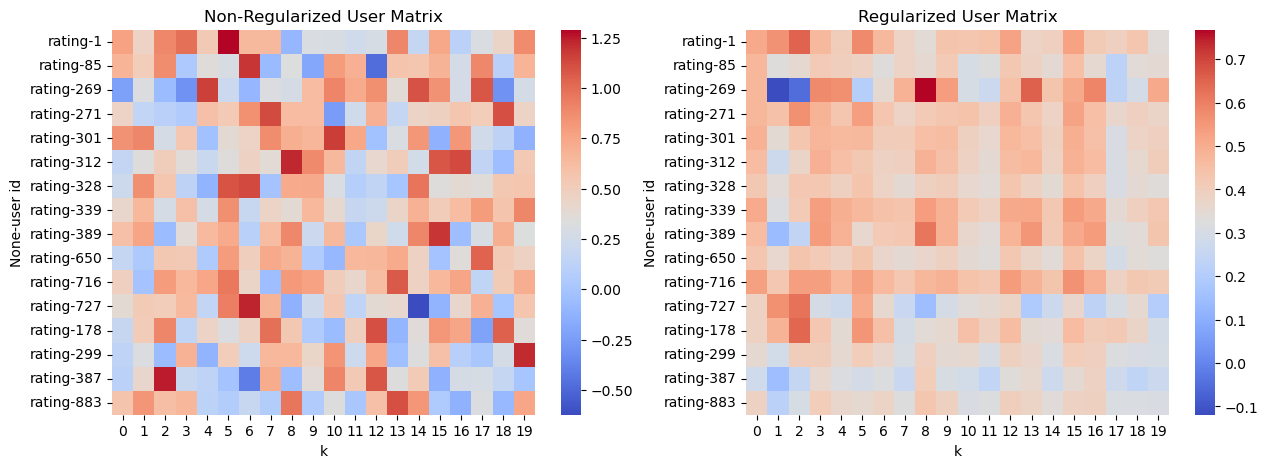

In [21]:
# Heatmap for Non-Regularized User Matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(output_noreg['U'], cmap='coolwarm', cbar=True) 
plt.title('Non-Regularized User Matrix') 

# Heatmap for Regularized User Matrix
plt.subplot(1, 2, 2)
sns.heatmap(output_reg['U'], cmap='coolwarm', cbar=True)
plt.title('Regularized User Matrix')

Heatmaps allow us to visually compare the distributions of the non-regularized and regularized user matrices. As we can tell from the two visualizations, the non-regularized user matrix has a variety of dark and light shades from blue to red. This indicates that the values in the matrix are more spread out. This could mean that the non-regularized model is overfitting its training data and is capturing more random variation. In contrast, the regularized user matrix has more shades of lighter colors and seems to be more evenly colored. This indicates that the regularization of this matrix captures less random variation and possibly has better generalization for data that isn't captured. As a result, the differences in these patterns align with the concept of regularization, as the goal of regularization is to improve generalization and reduce overfitting of values. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported **by evidence**, such as code implementation and results.

**SOLUTION**

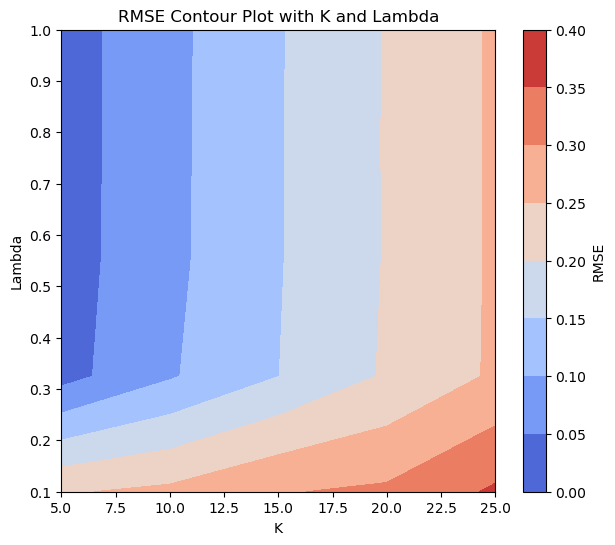

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create the ranges for K and lambda
K_range = np.arange(5, 30, 5)  
lambda_range = np.linspace(0.1, 1.0, 5) 

# Create arrays for RMSE values
RMSE = np.zeros((len(K_range), len(lambda_range)))

# Compare values of K and lambda
for i, K in enumerate(K_range):
    for j, lam in enumerate(lambda_range):
        output = compute_UV_reg(Rsmall, K=K, lam=lam, alpha=0.001)
        RMSE[i, j] = output['rmse']['rmse'].iloc[-1]

K_mesh, lambda_mesh = np.meshgrid(K_range, lambda_range)

# Create contour plot 
plt.figure(figsize=(7, 6))
contour_plot = plt.contourf(K_mesh, lambda_mesh, RMSE, cmap='coolwarm')
plt.colorbar(contour_plot, label='RMSE')
plt.xlabel('K')
plt.ylabel('Lambda')
plt.title('RMSE Contour Plot with K and Lambda')
plt.show()

A contour plot is effective to see different RMSE values with holding K constant and changing lambda values, and vice versa. As a result, using this visualization is good to seeing how to choose the most optimal values of K and lambda. Looking at this visualization, we can see that smaller K values and higher lambda values will give us the lowest RMSE score. 

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

Note: In this part, 
- Creating a new data `Rmedium` by `ratings_stacked.pkl` and `Rsmall`,
    1. Loading `rantings_stacked.pkl` and adding the `user id` having less than 134 NA's in it to `user id` in `Rsmall`,
    2. Adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`,
    3. Name the new dataset as `Rmedium` and use `Rmedium` to do clustering.
- Using the 'best' model you select in Question 2e to compute `UVstd`.

**SOLUTION**

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Loading rantings_stacked.pkl
np.random.seed(134) # set seed for tests
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()

# Add movies
movie_id = np.unique(np.concatenate([np.array(Rsmall.index.get_level_values('movie id')), np.arange(134, 235)])) - 1

# Filter users based on number of NAs
user_id_na = []
for i in range(1,Rbig.shape[1]):
    na_count = Rbig.iloc[movie_id, Rbig.columns.get_level_values('user id') == i].isna().sum().values[0] # movi
    if na_count < 134:
        user_id_na.append(i)
user_id = np.unique(np.concatenate((user_id_na, Rsmall.columns.get_level_values('user id'))))
user_id = user_id - 1

# Create Rmedium to include users
Rmedium = Rbig.iloc[movie_id, user_id]

output = compute_UV_reg(Rmedium, K=20, lam=4, alpha=0.001)
Uhat, Vhat = output['U'].to_numpy(), output['V'].to_numpy()
scaler = StandardScaler()
Uhat_std = scaler.fit_transform(Uhat)
Vhat_std = scaler.fit_transform(Vhat)

UVstd = np.concatenate([Uhat_std, Vhat_std], axis=0)

# Hierarchical clustering
h_cluster = AgglomerativeClustering(n_clusters=5)
h_cluster_labels = h_cluster.fit_predict(UVstd)

# K-means clustering
kmeans_cluster = KMeans(n_clusters=5)
kmeans_cluster_labels = kmeans_cluster.fit_predict(UVstd)

# Metrics for hierarchical clustering 
silhouette_h = silhouette_score(UVstd, h_cluster_labels)
calinski_harabasz_h = calinski_harabasz_score(UVstd, h_cluster_labels)
davies_bouldin_h = davies_bouldin_score(UVstd, h_cluster_labels)

# Metrics for K-means clustering
silhouette_k = silhouette_score(UVstd, kmeans_cluster_labels)
calinski_harabasz_k = calinski_harabasz_score(UVstd, kmeans_cluster_labels)
davies_bouldin_k = davies_bouldin_score(UVstd, kmeans_cluster_labels)

# Print metrics
print("Hierarchical Clustering Metrics:")
print(f"Silhouette Score: {silhouette_h:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_h:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_h:.3f}\n")

print("K-Means Clustering Metrics:")
print(f"Silhouette Score: {silhouette_k:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_k:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_k:.3f}")

Hierarchical Clustering Metrics:
Silhouette Score: 0.073
Calinski-Harabasz Index: 70.872
Davies-Bouldin Index: 3.685

K-Means Clustering Metrics:
Silhouette Score: 0.104
Calinski-Harabasz Index: 85.114
Davies-Bouldin Index: 2.880


**Silhouette Score:** 
The silhouette score, which ranges from -1 to 1, measures how similar an object is to its cluster, as well as comparing it to other clusters. A high silhouette score indicates that the clusters are more well-defined. Looking at both results, we can see that the silhouette scores for both clusters are pretty low, with the K-means cluster being a little higher. This means that some clusters might have some overlap, with the K-means clusters having better separation than those of hierarchical clusters. 

**Calinski-Harabasz Index:**
The Calinski-Harabasz index measures the ratio of the sum of dispersion for between-clusters and within-clusters. A higher Calinski-Harabasz score indicates that a model has more defined clusters. Looking at both results, we can see that the K-means clusters have a higher Calinski-Harabasz score. This means that on average, the K-means clusters are better defined than those of hierarchical clusters.

**Davies-Bouldin Index:**
The Davies-Bouldin index measures the average distance between clusters and the size of the clusters themselves, with 0 being the lowest score. A lower Davies-Bouldin score indicates that there is better separation between the clusters. Looking at both results, we can see that the K-means clusters have a lower index than those of the hierarchical clusters. This means that the K-means have better clustering performance. 

**Overall:** 
Based on the metrics, it seems that overall, K-Means has a better clustering performance than Hierarchical clustering. This is because K-Means had better scores on all 3 cluster validation metrics. However, we can see that both clustering methods have a low silhouette score, meaning that overall, our data might not have well-separated clusters. Given the context of our problem, it seems that we do not have true labels. When it comes to choosing which is the better performance metric to use, it really depends on what we are trying to focus on in our problem. If we want well-defined and separate clusters, the silhouette score is the metric we want to use. If we are interested in having more distinct and compact clusters, then the Calinski-Harabasz index is more preferable. If we want to make sure that our clusters are distinctly different from each other, then we would use the Davies-Bouldin index. For the context of this problem, I would say that using K-means clustering, measured by a silhouette score, is the most indicative choice.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [ ]:
# install umap
# !pip install umap-learn

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


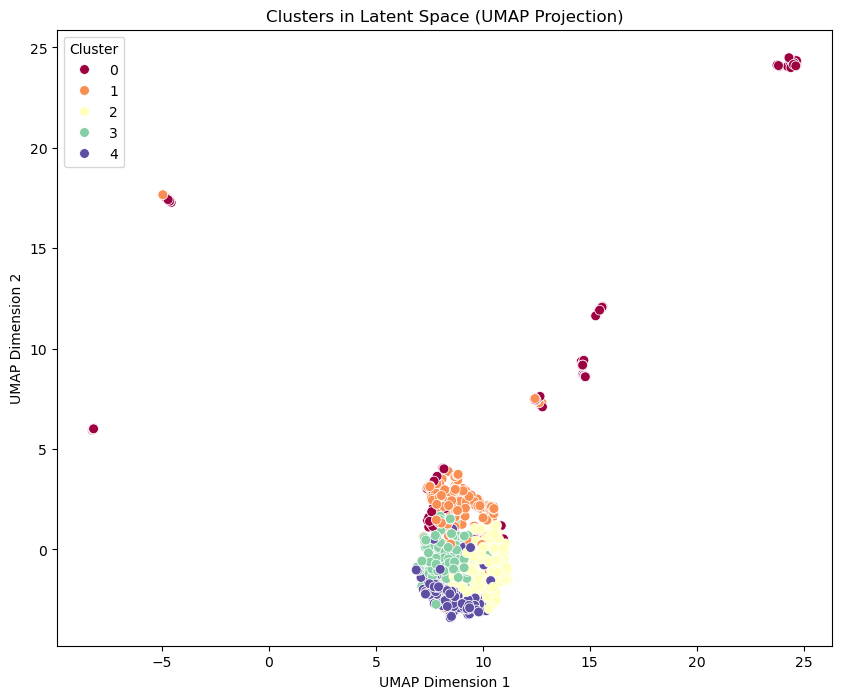

In [39]:
import umap
import matplotlib.pyplot as plt 
import seaborn as sns 

reducer = umap.UMAP(random_state=42)
UVstd_umap = reducer.fit_transform(UVstd)

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=UVstd_umap[:, 0], y=UVstd_umap[:, 1], hue=kmeans_cluster_labels, palette='Spectral', s=50)
plt.title('Clusters in Latent Space (UMAP Projection)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()

Comparing this UMAP projection with the clusters, we can see one main prominent cluster, where the data points of multiple clusters are closely packed together. There are also some smaller clusters that are very separated from the main cluster, which could represent outliers or distinct groups in the latent space. Overall, while the UMAP projection has a general grouping of clusters, there are distinct sub-groups that lie very far away from the main cluster. In addition, the clusters from the previous problem are somewhat consistent with this UMAP projection, but the complexity of the UMAP projection can suggest that a deeper analysis or perhaps a different clustering approach might be needed to gain a better understanding of the data. 

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)